In [1]:
import os, sys, re, csv, pymorphy2, string, math
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
py_path = os.environ['PYTHONPATH'].split(os.pathsep)[0]

f = open(py_path+'/site-packages/stop_words/stop-words/english.txt', 'r')

In [3]:
STOP_WORDS = [x.strip() for x in f.readlines()]

In [4]:
class TextAnalyzer():
    def __init__(self, text, size=5):
        
        morph = pymorphy2.MorphAnalyzer()
        self.sentences = text.translate(str.maketrans("", "", string.punctuation.replace(".", ""))).split('.')
        text = text.translate(str.maketrans( "", "", string.punctuation ) )
        
        words = []
        for word in text.split():
            norm_form = morph.parse(word)[0].normal_form
            words.append(norm_form)
        
        self.words_frequency = Counter(words)
        self.diff_coef = 4
        self.words = words
        self.ngram_list = { 1: Counter( [ w for w in words if w not in STOP_WORDS ] ) }
        for i in range(1, size):
            self.ngram_list[i] = self.get_ngram_freq(words, i)
        self.N = len(self.ngram_list[1])

    def get_ngram_freq(self, text, size):
        i = 0
        length = len(text) - size + 1
        res = {}
        while i < length:
            ngram = text[i:i + size]
            key = ' '.join(ngram)
            if not self.is_stopword(ngram):
                if key in res:
                    res[key] += 1
                else:
                    res[key] = 1
            i += 1
        return res

    def most_common_words(self, amount):
        print("Top {0} words".format(amount))
        for word, count in self.ngram_list[1].most_common(amount):
            print("{0} : {1}".format(word, count))

    def is_stopword(self, ngram):
        return [word for word in ngram if word in STOP_WORDS]

    def f(self, params):
        if isinstance(params, str):
            return self.ngram_list[1][params]
        else:
            key = ' '.join(params)
            if key in self.ngram_list[len(params)]:
                return self.ngram_list[len(params)][key]
            else:
                return 0
    
    def get_collocation_table(self, word, ngram_size):
        res = []
        ngrams_count = self.ngram_list[ngram_size]
        for ngram in ngrams_count:
            if word in ngram:
                res.append([ngram, ngrams_count[ngram]])
        return res
    def get_collocation_list(self, n):
        d = self.ngram_list[n]
        return [[k, d[k]] for k in sorted(d, key=d.get, reverse=True) if d[k] >= 4]

    def get_terms(self, n):
        group = {}
        for ngram in self.ngram_list[n+1]:
            w = ngram.split()
            if w[0] not in group:
                group[w[0]] = [w[1:]]
            else:
                group[w[0]].append(w[1:])

    # сортировка по словам 

        terms = []
        for least_part in group.values():
            least_part.sort(reverse=True)
            #least_part.sort(key=lambda x: self.f(x), reverse=True)
            for i in range(len(least_part) - 1):
                diff = self.f(least_part[i]) / self.f(least_part[i + 1])
                if diff >= self.diff_coef and least_part[i] not in terms: # ДУБЛИРУЮТСЯ ТЕРМИНЫ 
                    terms.append(least_part[i])
        return terms

    def get_mi(self, key):
        bigramm = key.split(' ')
        return math.log2((self.f(bigramm)*self.N)/(self.words_frequency[bigramm[0]]*self.words_frequency[bigramm[1]]))

    def get_t_score(self, key):
        bigramm = key.split(' ')
        return (self.f(bigramm) - (self.words_frequency[bigramm[0]]*self.words_frequency[bigramm[1]])/(self.N))/(math.sqrt(self.f(bigramm)))
     
    def get_log_likehood(self, key):
        bigramm = key.split(' ')

        O = [[0 for x in range(2)] for y in range(2)]
        E = [[0 for x in range(2)] for y in range(2)]
        
        O[0][0] = self.f(bigramm)
        O[0][1] = self.f(bigramm[0]) - self.f(bigramm)
        O[1][0] = self.f(bigramm[1]) - self.f(bigramm)
        O[1][1] = self.N - self.f(bigramm[0]) - self.f(bigramm[1]) + self.f(bigramm)

        E[0][0] = (O[0][0] + O[0][1])*(O[0][0] + O[1][0])/self.N
        E[0][1] = (O[0][0] + O[0][1])*(O[1][0] + O[1][1])/self.N 
        E[1][0] = (O[0][0] + O[1][0])*(O[1][0] + O[1][1])/self.N
        E[1][1] = (O[0][0] + O[1][0])*(O[1][0] + O[1][1])/self.N

        res = 0
        for i in range(2):
            for j in range(2):
                if O[i][j]*E[i][j] <= 0:
                    return math.inf
                else:
                    res += O[i][j]*math.log(O[i][j]/E[i][j])
        return res*2

    def to_file(self, filename, n, amt = 35):
        with open(filename, 'w') as f:
            d = ta.get_ngram_freq(ta.words, 2)
            l = [[k, d[k]] for k in sorted(d, key=d.get, reverse=True)]
            wr = csv.writer(f)
            wr.writerow(['collocations', 'word freq', 'MI', 't-score', 'loglikelihood'])
            length = min(len(l), amt)
            data = []
            for i in range(length): 
                collocation = l[i]
                collocation += [self.get_mi(collocation[0]), self.get_t_score(collocation[0]), self.get_log_likehood(collocation[0])]
                print(collocation)
                data.append(collocation)
            for elem in data:
                wr.writerow(elem)

In [5]:
#open input text in this case Pride and Prejustice is used
f = open('../plain.txt', 'r')
ta = TextAnalyzer(f.read())

In [6]:
def get_connection_graph(ngrams):
    connections = {}
    for sentence in ta.sentences:
        sentence_bonds = []
        for term in ngrams:
            if isinstance(term, str):
                temp = term
            else: 
                temp = ' '.join(term)
            if temp in sentence:
                sentence_bonds.append(temp)
        if len(sentence_bonds) > 1:
            for i in range(len(sentence_bonds)):
                for j in range(len(sentence_bonds)):
                    if i != j:
                        if sentence_bonds[i] in connections:
                            connections[sentence_bonds[i]] += [sentence_bonds[j]]
                        else:
                            connections[sentence_bonds[i]] = [sentence_bonds[j]]

    g = nx.Graph()
    g.add_nodes_from(connections.keys())
    for k, v in connections.items():
        g.add_edges_from(([(k, t) for t in v]), length=10)

    #pos = nx.spring_layout(g, scale = 20, k=15/math.sqrt(g.order()))
    pos = nx.spring_layout(g, scale = 5)
    nx.draw(g, pos, node_size=10, alpha=0.5, width=0.1,
            arrows=False, node_color='g', font_size=3, with_labels=True)
    plt.savefig('abc.png', dpi=300)    
        
    return connections

In [6]:
ta.get_terms(2)

[['gutenbergtm', 'work'],
 ['gutenbergtm', 'trademark'],
 ['gutenbergtm', 'license'],
 ['gutenbergtm', 'electronic'],
 ['gutenberg', 'literary'],
 ['gutenberg', 'ebook'],
 ['literary', 'archive'],
 ['saw', 'anything'],
 ['mr', 'collins'],
 ['make', 'haste'],
 ['mrs', 'gardiners'],
 ['good', 'news'],
 ['“how', 'can'],
 ['mrs', 'bennet'],
 ['mr', 'wickhams'],
 ['“my', 'dear'],
 ['elizabeth', 'bennet'],
 ['eldest', 'sister'],
 ['dearest', 'lizzy'],
 ['dear', 'sir'],
 ['dear', 'lizzy'],
 ['dear', 'jane'],
 ['dear', 'dear'],
 ['dear', 'aunt'],
 ['mr', 'bennet'],
 ['miss', 'eliza'],
 ['darcy', 'though'],
 ['darcy', 'might'],
 ['darcy', 'looked'],
 ['bingley”', 'said'],
 ['bennet', '“and'],
 ['young', 'lady'],
 ['thousand', 'pounds'],
 ['must', 'speak'],
 ['mrs', 'long'],
 ['“i', 'never'],
 ['lady', 'catherine'],
 ['mrs', 'phillips'],
 ['give', 'way'],
 ['mr', 'wickham'],
 ['mr', 'bingley”'],
 ['every', 'thing'],
 ['“i', 'know'],
 ['“i', 'can'],
 ['“and', 'pray'],
 ['mr', 'darcy'],
 ['mr', 'b

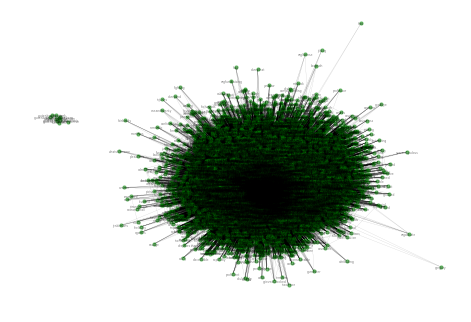

In [55]:
word_connection = get_connection_graph(list(ta.ngram_list[1].keys()))
bi_connection = get_connection_graph(ta.get_terms(2))

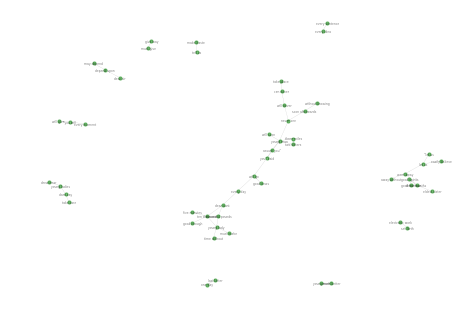

In [8]:
bi_connection = get_connection_graph(ta.get_terms(2))

In [56]:
import numpy as np

In [57]:
def weighted_choice(choices):
    total = sum(ta.f(col.split()) for col in choices)
    r = np.random.randint(0, total)
    upto = 0
    for col in choices:
        if upto + ta.f(col.split()) > r:
            return col
        upto += ta.f(col.split())

In [64]:
bg = list(bi_connection.keys())
curr_bigram = bg[np.random.randint(0, len(bg))]

summary = []

sentence_amt = 10
sentence_len = 10
bg = list(bi_connection.keys())
curr_bigram = bg[np.random.randint(0, len(bg))]
summary += curr_bigram
summary
for amt in range(sentence_amt):
    curr_word = curr_bigram.split()[-1]
    for l in range(sentence_len):
        curr_word = weighted_choice(list(set(word_connection[curr_word])))
        summary += ' ' + curr_word
    curr_bigram = weighted_choice(list(set(bi_connection[curr_bigram])))
    summary += '. ' + curr_bigram
        

In [65]:
''.join(summary)

'forster will man heard come mary sister dwelling gardiner came years never. colonel forster say walked william sisters arrival without netherfield long husbands whose. thousand pounds eliza neither miss darcy lord town mr hardly elizabeth prey. dear aunt elizabeth lydia mr parsonage elizabeth sister either elizabeth mr comparative. miss lucas mr lambton elizabeth hope housekeeper hardly two till lydias character. elizabeth wished appear appearing rosings elizabeth evening believed mr darcy great accident. lady catherine man darcy never will rivers shall wickham married plan elizabeth. miss bennet deep almost reach darcys civil since mrs sir sometimes friends. colonel fitzwilliam doubted see though talk elizabeth quite mr among must elizabeth. miss bennet elizabeth undoubtedly lady bennet mr silence without walk chance walking. elizabeth said'

In [35]:
words = ' '.join(ta.sentences).split()

In [36]:
def getNGramSentenceRandom(gram, word, n = 50):
    res = ""
    for i in range(n):
        res += " " + word
        choices = [element[0] for element in gram if element[0].split()[0] == word]
        if not choices:
            break
        
        word = weighted_choice(choices)
    return res

In [33]:
gram

[['lady catherine', 208],
 ['mr darcy', 162],
 ['colonel fitzwilliam', 155],
 ['mrs bennet', 129],
 ['sir william', 106],
 ['mr collins', 105],
 ['colonel forster', 95],
 ['said elizabeth', 78],
 ['mr bingley', 75],
 ['miss bingley', 72],
 ['melancholy conviction', 59],
 ['project gutenbergtm', 59],
 ['miss bennet', 57],
 ['young man', 55],
 ['ruining perhaps', 55],
 ['beloved sister', 55],
 ['words mr', 55],
 ['mr bennet', 53],
 ['mrs gardiner', 50],
 ['de bourgh', 49],
 ['elizabeth sister', 46],
 ['mr wickham', 46],
 ['elizabeth felt', 39],
 ['wickham among', 39],
 ['red coats', 39],
 ['young ladies', 37],
 ['elizabeth elizabeth', 37],
 ['miss darcy', 34],
 ['elizabeth mother', 34],
 ['dear aunt', 33],
 ['dare say', 30],
 ['elizabeth saw', 30],
 ['cried elizabeth', 30],
 ['young lady', 28],
 ['project gutenberg', 28],
 ['replied elizabeth', 26],
 ['jane bennet', 26],
 ['mr gardiner', 26],
 ['mrs collins', 26],
 ['ten years', 26],
 ['bennet bennet', 25],
 ['great deal', 25],
 ['mr dar

In [19]:
d = ta.ngram_list[2]


{'truth universally': 1,
 'universally acknowledged': 1,
 'single man': 2,
 'good fortune': 3,
 'fortune must': 1,
 'wife however': 1,
 'however little': 3,
 'little known': 1,
 'man may': 1,
 'man first': 1,
 'first entering': 1,
 'well fixed': 1,
 'surrounding families': 1,
 'rightful property': 1,
 'daughters mr': 2,
 'mr bennet': 53,
 'bennet said': 8,
 'said bennet': 13,
 'bennet lady': 1,
 'bennet one': 5,
 'one day': 8,
 'netherfield park': 1,
 'bennet replied': 7,
 'mrs long': 13,
 'wife told': 1,
 'truth mr': 1,
 'bennet made': 4,
 'truth cried': 1,
 'cried bennet': 5,
 'bennet wife': 13,
 'wife impatiently': 1,
 'invitation enough': 1,
 'must know': 8,
 'know bennet': 5,
 'bennet long': 1,
 'long says': 1,
 'young man': 55,
 'large fortune': 4,
 'bennet came': 4,
 'much delighted': 1,
 'bennet agreed': 1,
 'bennet morris': 1,
 'morris immediately': 1,
 'take possession': 2,
 'bennet servants': 1,
 'next week': 3,
 'bennet name': 3,
 'name bingley': 1,
 'bennet married': 1,
 '

In [56]:
ta.to_file('bigrams.csv', 2)

['mr darcy', 218, 2.6943944883140105, 12.483773686995164, 44139.82467503231]
['mrs bennet', 136, 3.5188382503886375, 10.644499437897139, 50031.88667192419]
['mr collins', 122, 3.084862206847461, 9.743562242026574, 57187.559138361445]
['lady catherine', 95, 5.285440433418661, 9.496883160909007, 66887.86850193255]
['mr bingley', 82, 1.8060328907590395, 6.465760293980902, 48737.29290832613]
['mr bennet', 73, 1.4389966367975662, 5.392772465506061, 46383.484998718086]
['miss bingley', 68, 3.031563653643889, 7.237741531028888, 52055.11168816931]
['mr wickham', 60, 1.994781766493007, 5.802458038915379, 55629.5072032263]
['project gutenbergtm', 56, 6.581336725902745, 7.405167425006807, inf]
['miss bennet', 53, 2.4727124587333424, 5.968582652624993, 49484.24786409506]
['mrs gardiner', 51, 3.888072060054357, 6.6590823271271615, 69616.27319532413]
['said elizabeth', 42, 0.5015628087371455, 1.9031264204937022, 35371.52144762644]
['sir william', 38, 6.874507332472554, 6.111877775239916, 84113.63307

In [10]:
len(ta.get_terms(3))

18